In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

In [3]:
with open('results/2019-11-16_12-35-14_smooth_monotonic/smooth_monotonic_modeling_result.pkl', 'rb') as handle:
    x = pickle.load(handle)

In [4]:
x
x_subsample = x.final.b_nn_corrected[12000:25000:10]
time_subsample = x.base_signals.t_b_nn[12000:25000:10]
time_subsample = time_subsample.reshape(-1,1)
np.size(time_subsample)

1300

In [5]:
N = 39195
a = np.floor(N / 200)
print(a)
len(list(range(0,N, int(a))))

195.0


201

In [6]:
def downsample_to(x, n):
    return downsample(x, int(np.floor(np.size(x) / n)))
    
def downsample(x, n):
    return np.array([np.median(x[i:n+i]) for i in range(0,np.size(x),n)])

In [7]:
x_downsampled_a = downsample_to(x.final.a_nn_corrected, 1000)
time_downsampled_a = downsample_to(x.base_signals.t_a_nn, 1000)
time_downsampled_a = time_downsampled_a.reshape(-1, 1)
x_downsampled_a.shape

(1001,)

In [8]:
x_downsampled_b = downsample_to(x.final.b_nn_corrected, 1000)
time_downsampled_b = downsample_to(x.base_signals.t_b_nn, 1000)
time_downsampled_b = time_downsampled_b.reshape(-1, 1)
x_downsampled_b.shape

(1003,)

In [9]:
np.size(downsample_to(x.final.b_nn_corrected, 500))

502

In [10]:
mean = np.mean(np.concatenate((x_downsampled_a, x_downsampled_b), axis=0))

In [11]:
mean = np.mean(np.concatenate((x_downsampled_a, x_downsampled_b), axis=0))
x_downsampled_a_normalized = x_downsampled_a - mean
x_downsampled_b_normalized = x_downsampled_b - mean

x_all = np.concatenate((x_downsampled_a_normalized, x_downsampled_b_normalized), axis=0)
time_all = np.concatenate((time_downsampled_a, time_downsampled_b), axis=0)

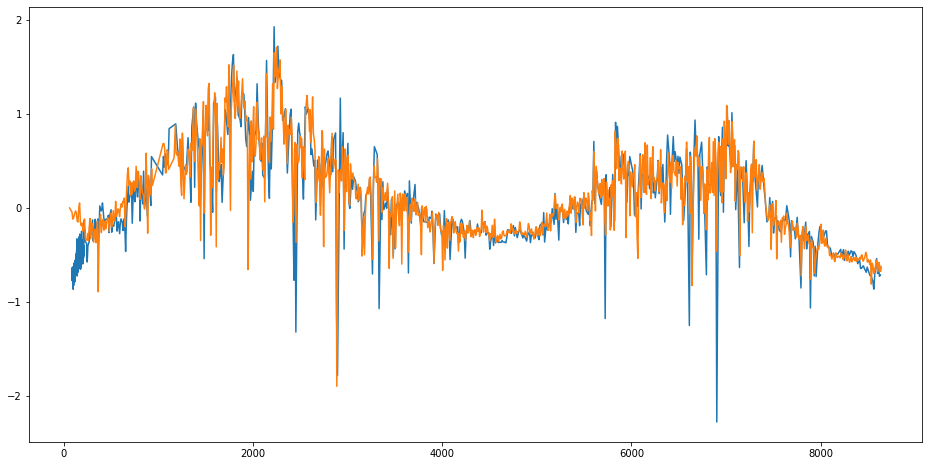

In [12]:
plt.figure(5, figsize=(16, 8))
plt.plot(time_downsampled_b, x_downsampled_b_normalized, time_downsampled_a, x_downsampled_a_normalized)

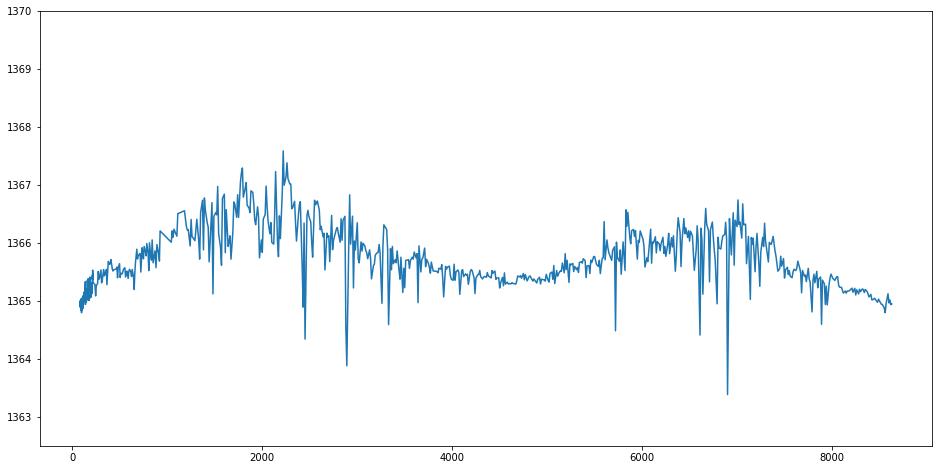

In [13]:
plt.figure(5, figsize=(16, 8))
plt.ylim(1362.5, 1370)
plt.plot(time_downsampled_b, x_downsampled_b)

In [697]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel

import time

In [508]:
#kernel = ConstantKernel() * (WhiteKernel() + RationalQuadratic() + ExpSineSquared())

In [712]:
kernel = RBF(1, (1e-3, 1e3)) + WhiteKernel(1, (1e-5, 1e5))

In [705]:
kernel = Matern(length_scale=1, length_scale_bounds=(1e-3, 1e3), nu=2.5) + WhiteKernel(1e4, (1e-5, 1e5))

In [511]:
kernel = RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-5, 1e5), alpha_bounds=(1e-5, 1e5))+ WhiteKernel(1e4, (1e-5, 1e5))

In [512]:
kernel = ExpSineSquared(length_scale=1, periodicity=1, length_scale_bounds=(1e-5, 1e5), periodicity_bounds=(1e-5, 1e5)) + WhiteKernel(1e4, (1e-5, 1e5))

In [517]:
kernel = DotProduct(1, (1e-5, 1e5)) + WhiteKernel(1, (1e-5, 1e5))

In [713]:
start = time.time()

gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=1)
gpr.fit(time_all, x_all)

end = time.time()
print(end - start)

87.44170212745667


In [714]:
gpr.log_marginal_likelihood()

-164.29571520230866

In [715]:
time_to_predict = np.linspace(0, np.max(time_all), 1000).reshape(-1,1)

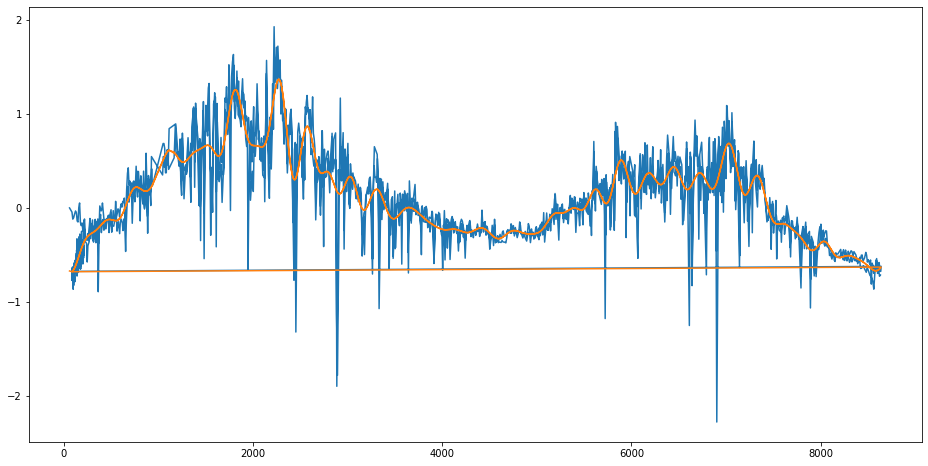

In [716]:
plt.figure(5, figsize=(16, 8))
plt.plot(time_all, x_all, time_all, gpr.predict(time_all))

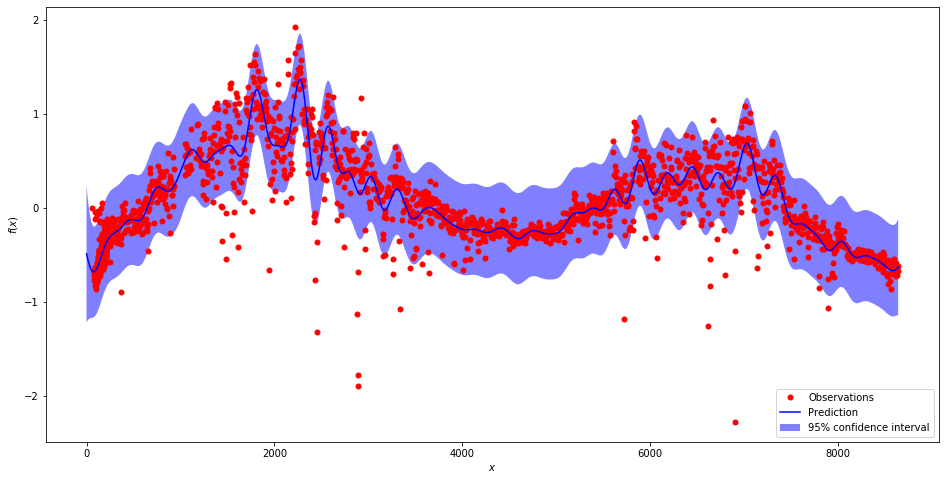

In [718]:
X = time_all
y = x_all
y_pred, sigma = gpr.predict(time_to_predict, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(time_to_predict, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([time_to_predict, time_to_predict[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
#plt.ylim(1363, 1368)
#plt.xlim(0, 2000)
plt.legend(loc='lower right')
#plt.savefig('gp_conf_int.pdf')

# With CrossValidation

In [293]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel

In [305]:
kernel = RBF() + WhiteKernel()

In [306]:
class GaussianProcessRBF: 
    def __init__(self, alpha=1, length_scale=1):
        self.alpha = alpha
        self.length_scale = length_scale
        
    def fit(self, x, y):
        self.model = GaussianProcessRegressor(kernel=RBF(self.length_scale), random_state=0, alpha=self.alpha).fit(x, y)
        return self.model
    
    def predict(self, x, return_std=False):
        return self.model.predict(x, return_std=return_std)
    
    def get_params(self, deep=True):
        return {'alpha' : self.alpha,
                'length_scale' : self.length_scale,
                }
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [307]:
parameters = {'alpha':[(2*i)*10**j for i in range(5) for j in range(0,4)],
              'length_scale':[10 ** i for i in range(-4,4)]}

In [308]:
clf = RandomizedSearchCV(GaussianProcessRBF(), 
                         parameters, 
                         cv=10, 
                         n_jobs=-1, 
                         scoring='r2',
                         iid=False,
                         verbose=10)

In [309]:
clf.fit(time_subsample, x_subsample_normalized)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1175s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=<__main__.GaussianProcessRBF object at 0x1a57709d30>,
                   iid=False, n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': [0, 0, 0, 0, 2, 20, 200, 2000,
                                                  4, 40, 400, 4000, 6, 60, 600,
                                                  6000, 8, 80, 800, 8000],
                                        'length_scale': [0.0001, 0.001, 0.01,
                                                         0.1, 1, 10, 100,
                                                         1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='r2', verbose=10)

In [310]:
clf.best_estimator_

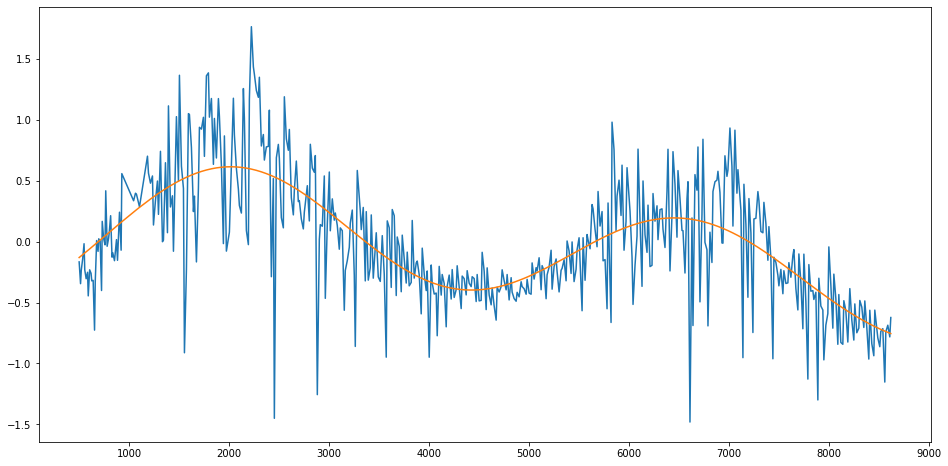

In [311]:
plt.figure(5, figsize=(16, 8))
plt.plot(time_subsample, x_subsample_normalized, time_subsample, clf.predict(time_subsample))

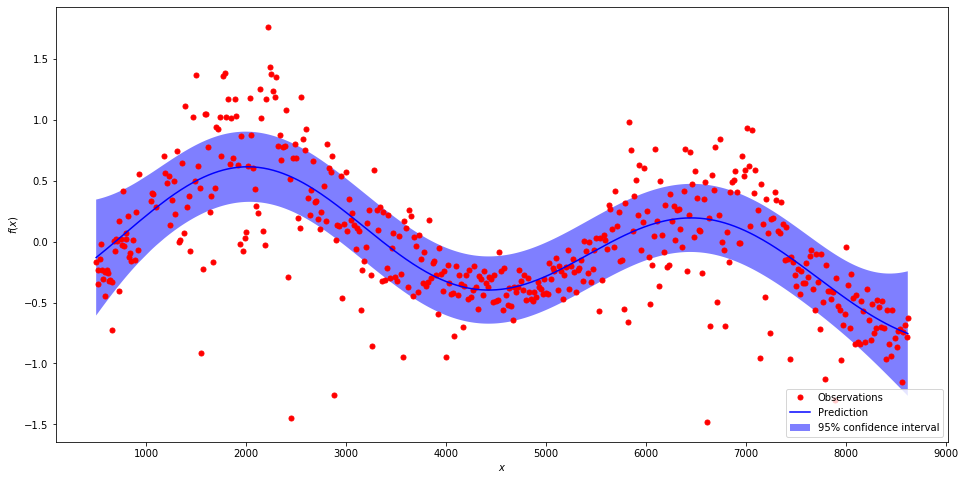

In [312]:
X = time_subsample
y = x_subsample_normalized
y_pred, sigma = clf.best_estimator_.predict(time_subsample, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(time_subsample, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([time_subsample, time_subsample[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
#plt.ylim(1363, 1368)
#plt.xlim(2000, 4000)
plt.legend(loc='lower right')

# Fourier tranform

In [165]:
S = np.abs(np.fft.fft(x_subsample - np.mean(x_subsample)))
x_filtered = np.fft.fft(x_subsample - np.mean(x_subsample)).copy()
x_filtered[S<50] = 0
x_filtered = np.fft.ifft(x_filtered)

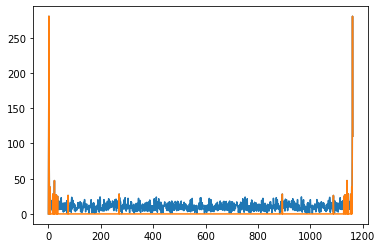

In [166]:
plt.plot(np.abs(np.fft.fft(x_subsample - np.mean(x_subsample))))
plt.plot(S_filtered)

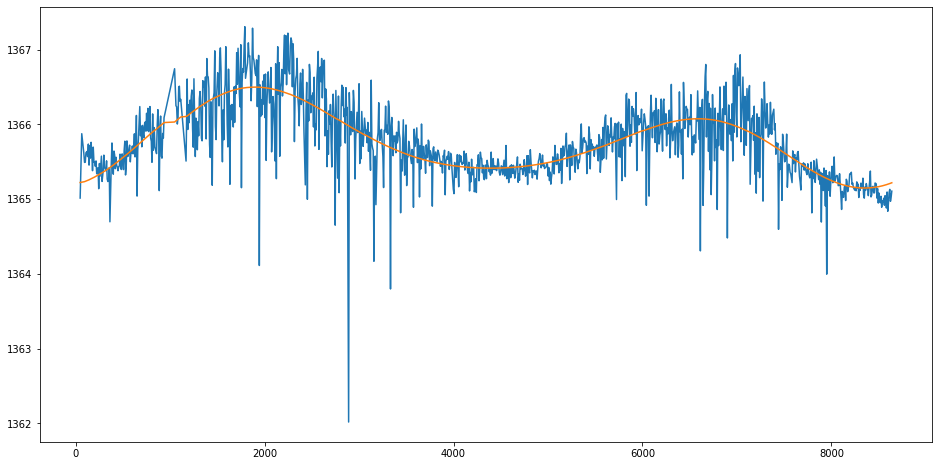

In [167]:
plt.figure(5, figsize=(16, 8))
plt.plot(time_subsample, x_subsample, time_subsample, x_filtered + np.mean(x_subsample))

# Kalman filter

In [269]:
from pykalman import KalmanFilter
from scipy.interpolate import interp1d

In [270]:
signal_a, sihnal_b = x.final.a_nn_corrected, x.final.b_nn_corrected
time_a, time_b = x.base_signals.t_a_nn, x.base_signals.t_b_nn
mean_signal = np.mean(np.concatenate((signal_a, signal_b), axis=0))
a, b = interp1d(time_a, signal_a - mean_signal), interp1d(time_b, signal_b- mean_signal)

In [291]:
time_interval = (max(time_a[0], time_b[0]), min(time_a[-1], time_b[-1]))
time_sample = np.linspace(time_interval[0], time_interval[1], 2000)

In [292]:
a_sample = a(time_sample)
b_sample = b(time_sample)

In [293]:
data = np.stack((a_sample, b_sample), axis=1)

In [294]:
data.shape

(2000, 2)

In [295]:
kf = KalmanFilter(n_dim_obs=2,
                  initial_state_mean = 0,
                  transition_matrices = [[1]],
                  transition_offsets = 0,
                  observation_matrices = [[1],[1]],
                  observation_offsets = [0,0],
                  em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance'])
kf.em(data)

(-3, 3)

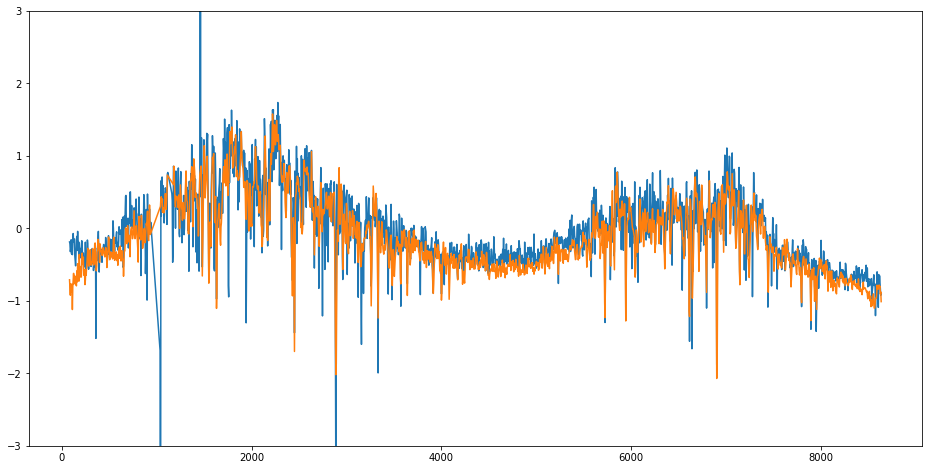

In [296]:
plt.figure(5, figsize=(16, 8))
plt.plot(time_sample, a_sample, time_sample, b_sample)
plt.ylim(-3, 3)

In [297]:
x_smoothed_mean, x_smoothed_covariance = kf.smooth(data)

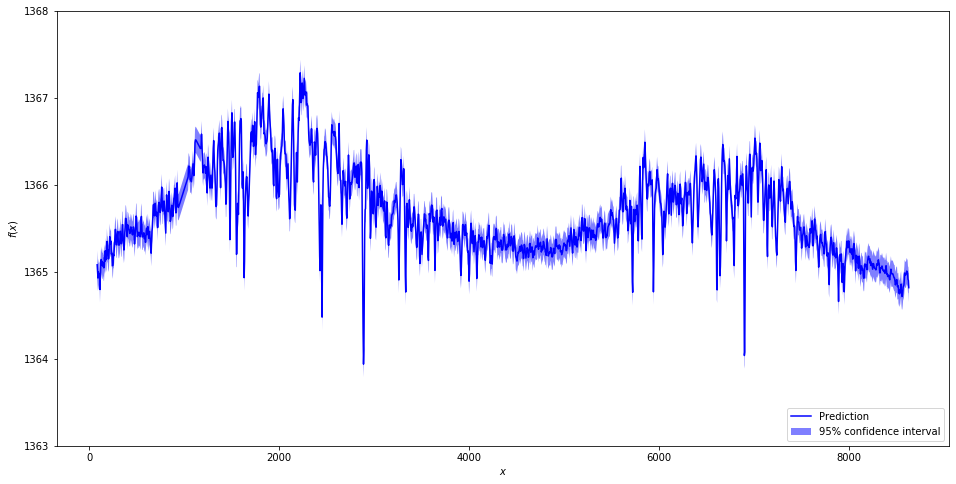

In [298]:
X = time_sample
#y = x_subsample
y_pred, sigma = x_smoothed_mean.ravel() + mean_signal, np.sqrt(x_smoothed_covariance.ravel())

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(5, figsize=(16, 8))
#plt.plot(time_sample, a_sample + np.mean(signal_a), 'r.', markersize=10, label='Observations')
#plt.plot(time_sample, b_sample , 'r.', markersize=10, label='Observations')
#plt.plot(time_b, signal_b)
plt.plot(time_sample, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([time_sample, time_sample[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(1363, 1368)
plt.legend(loc='lower right')

In [300]:
x_smoothed_mean.shape

(2000, 1)